# Import 

In [1]:
import numpy as np 
import scipy as sp
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree



In [2]:
from module.data_prep_celegans import celegans_data, syn_to_edge

from module.Ceval.dendrogram_eval import get_clustering_stats

In [3]:
from module.dendorgram_utils import dendrogram_clustering
from module.data_prep import prep_grn_data, prep_go_meta, prep_tf_fam_dict, prep_foodweb_data, prep_recipe_data
from module.bipartite_vectorisation import agg_list, get_bpt_dict, all_ud_bpt_vectors, bpt_list
from module.enrichment_utils import get_clustersize_range, one_test
from fvec import bipartite_cooarray, csr_row_norm, adjacency_cooarray

from module.graphpeeler import layer_realisation

In [4]:
save_things = False

In [5]:
cwd = Path.cwd()

# Go two directories up
# two_levels_up = cwd.parent.parent
# print(two_levels_up)

In [6]:
data_dir = cwd.parent.parent / 'data' / 'celegans' / 'processed'

if save_things:
    fig_dir = cwd.parent / 'figures' / 'celegans'
    fig_dir.mkdir(parents=True, exist_ok=True)

In [7]:
edge_df, ce_meta = celegans_data()

chem_edges_df = syn_to_edge(edge_df, electrical=False)
all_edges_df = syn_to_edge(edge_df, electrical=True)

/Users/ssm47/Desktop/thesis_code/01_vectorisation/src/module/data_prep_celegans.py:74: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edge_df = pd.read_csv('../../data/celegans/white_1986_whole.csv', delim_whitespace=True)


In [8]:
strings_list = ['Anatomical cell class (WW Barry)', 'Cook cell category', 'Cell Class', 'Final classification']

shorthand = {'Anatomical cell class (WW Barry)':'cellclass', \
             'Cook cell category':'cook_ccat', \
             'Cell Class':'ncclass', 'Final classification':'fclass'}

edge_dict = {'chem':chem_edges_df, 'all':all_edges_df}


In [9]:
class_string = 'Cook cell category'
edgetype = 'all'

typeedge_df = edge_dict.get(edgetype)
class_name = shorthand.get(class_string)

In [10]:
all_norm_vec_df = pd.read_parquet(f'{data_dir}/{class_name}/V_{class_name}_{edgetype}_vec.parquet')

# Clustering:

In [11]:
to_cluster_meta = ce_meta[ce_meta['Final classification']!='unknown']
n_ids = to_cluster_meta.index.values

In [12]:
vec_to_cluster = all_norm_vec_df.loc[n_ids]

In [13]:
method='ward'
metric = 'euclidean'

# dist_func = sp.spatial.distance.pdist 

ind_to_id = vec_to_cluster.index.values
Z = linkage(vec_to_cluster, method=method, metric=metric) ####### linkage


In [14]:
cmap = mpl.colormaps['tab10']
cclasses=['Pharynx', 'sensory neuron', 'motor neuron', 'interneuron']
cmap_ind = [9, 1, 2, 4]
classmap = dict(zip(cclasses, [cmap(i) for i in cmap_ind]))


In [15]:
cat_to_plot = ['Final classification']
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all) 

plotobj = []

for cat in cat_to_plot:
    unique_cats = to_cluster_meta[cat].unique()
    print(unique_cats)

    arr, key = pd.factorize(cclasses + list(to_cluster_meta[cat]))

    arr[len(cclasses):]

    colors = mpl.colormaps['tab10'](cmap_ind)
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((arr, key, cluster_cmap))


['Pharynx' 'sensory neuron' 'interneuron' 'motor neuron']


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_50939/3325627650.py:10: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(cclasses + list(to_cluster_meta[cat]))


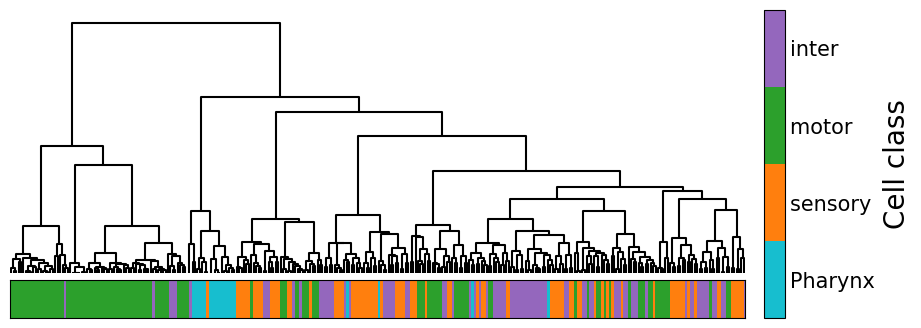

In [16]:
ncats = len(cat_to_plot) 

fig = plt.figure(figsize=(10, 3+ncats))

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    # ax.set_ylabel(cat_to_plot[n], rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label('Cell class', size=20)  # Set label text and size
    legend_ax.set_yticks(ticks=yticks)
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels([i.replace('neuron', '') for i in key], size=15)
    legend_ax.tick_params(length=0)

if save_things:
    plt.savefig(fig_dir / 'ce_v_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'ce_v_clustering.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [17]:
cat = 'Final classification'
cat = 'Cell Class'

cat_dict = to_cluster_meta.loc[ind_to_id].reset_index().groupby(cat).Neuron.apply(list).to_dict()
corrected_cat_dict = {key: val for key, val in cat_dict.items() if len(val)>1}

cl_stats_df = get_clustering_stats(Z=Z, ctype_to_id=corrected_cat_dict, ind_to_id=ind_to_id, ) # already handles single memeber labels in here actually

purity = cl_stats_df.m_p.sum()/cl_stats_df.len.sum()
mean_pms = cl_stats_df.pms.mean()
print('pure cluster coverage:', purity)
print('mean tightness:', mean_pms)

pure cluster coverage: 0.6094890510948905
mean tightness: 0.6652388973294193


In [19]:
cat = 'Final classification'

cat_dict = to_cluster_meta.loc[ind_to_id].reset_index().groupby(cat).Neuron.apply(list).to_dict()
corrected_cat_dict = {key: val for key, val in cat_dict.items() if len(val)>1}
cl_stats_df = get_clustering_stats(Z=Z, ctype_to_id=corrected_cat_dict, ind_to_id=ind_to_id, )

purity = cl_stats_df.m_p.sum()/cl_stats_df.len.sum()
mean_pms = cl_stats_df.pms.mean()
print('pure cluster coverage:', purity)
print('mean tightness:', mean_pms)

pure cluster coverage: 0.8166666666666667
mean tightness: 0.5124519230769231
